<a href="https://www.kaggle.com/code/davewilliamsdata/retail-sales-optimization?scriptVersionId=130746490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/retail-data-set/file_out2.csv
/kaggle/input/retail-data-set/file_out.csv


# Examining a small retail sales dataset to predict for high value sales.

In [2]:
retail = pd.read_csv('/kaggle/input/retail-data-set/file_out2.csv')
retail.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


In [3]:
retail = retail.drop('Unnamed: 0', axis=1)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   InvoiceID   29103 non-null  int64  
 1   Date        29103 non-null  object 
 2   ProductID   29103 non-null  int64  
 3   TotalSales  29103 non-null  float64
 4   Discount    29103 non-null  float64
 5   CustomerID  29103 non-null  int64  
 6   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.6+ MB


In [5]:
retail.Date = pd.to_datetime(retail.Date)
retail.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,329,2019-12-27,524,355.932203,64.067797,185,2
2,330,2019-12-27,192,901.694915,162.305085,230,4
3,330,2019-12-27,218,182.754237,32.895763,230,1
4,330,2019-12-27,247,780.101695,140.418305,230,4


In [6]:
len(retail.InvoiceID.unique())

14079

In [7]:
len(retail.ProductID.unique())

1940

In [8]:
retail.isna().sum()

InvoiceID     0
Date          0
ProductID     0
TotalSales    0
Discount      0
CustomerID    0
Quantity      0
dtype: int64

In [9]:
retail.ProductID.value_counts()

192     994
1756    824
1830    577
543     553
540     513
       ... 
1911      1
335       1
1509      1
1939      1
371       1
Name: ProductID, Length: 1940, dtype: int64

What products are purchased together?

In [10]:
sales_per_invoice = retail.groupby(by='InvoiceID')['TotalSales'].sum()

Creating a Quartiles column from the Total Sales column. Will use the high value sales (quartile 4) as a target for predicting.

In [11]:
retail['SalesQuartile'] = pd.qcut(retail.TotalSales, q=4, labels=[1, 2, 3, 4])
retail.head(20)

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,SalesQuartile
0,328,2019-12-27,1684,796.610169,143.389831,185,4,2
1,329,2019-12-27,524,355.932203,64.067797,185,2,1
2,330,2019-12-27,192,901.694915,162.305085,230,4,2
3,330,2019-12-27,218,182.754237,32.895763,230,1,1
4,330,2019-12-27,247,780.101695,140.418305,230,4,2
5,330,2019-12-27,252,1123.966102,202.313898,230,4,2
6,330,2019-12-27,486,1251.084746,225.195254,230,4,2
7,330,2019-12-27,487,805.084746,144.915254,230,2,2
8,330,2019-12-27,1793,1175.423729,211.576271,230,4,2
9,330,2019-12-27,975,966.101695,173.898305,230,4,2


In [12]:
high_sales = retail[retail.SalesQuartile == 4]
high_sales.ProductID.value_counts()

1756    302
1347    249
192     211
885     157
1167    147
       ... 
714       1
290       1
782       1
260       1
371       1
Name: ProductID, Length: 1252, dtype: int64

In [13]:
high_sales.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,SalesQuartile
11,330,2019-12-27,1559,2850.000000,513.000000,230,4,4
12,331,2019-12-27,1909,3053.389830,549.610170,458,3,4
18,334,2019-12-28,559,3305.084746,594.915254,420,20,4
19,334,2019-12-28,563,3813.559322,686.440678,420,20,4
23,334,2019-12-28,1842,3474.576271,625.423729,420,20,4


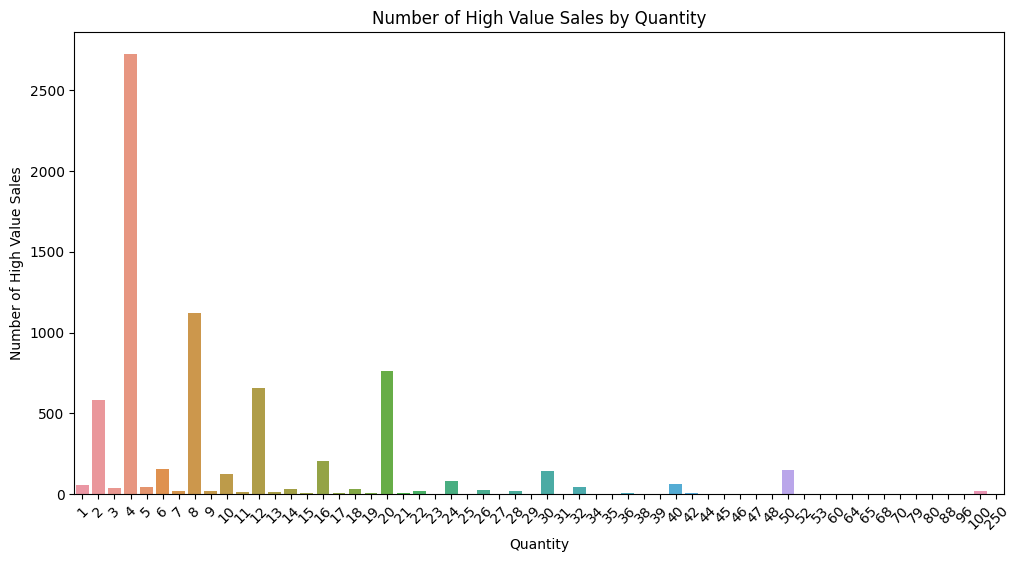

In [14]:
plt.rcParams["figure.figsize"] = (12,6)

sns.countplot(high_sales, x='Quantity')
plt.xticks(rotation=45)
plt.ylabel('Number of High Value Sales')
plt.title('Number of High Value Sales by Quantity')
plt.show()

As we can see having a higher quantity of products sold in a transaction is not always correlated with a higher overall value.

Creating a binary column for the high value sales.

In [15]:
retail['high_value'] = retail['SalesQuartile'] == 4
retail.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,SalesQuartile,high_value
0,328,2019-12-27,1684,796.610169,143.389831,185,4,2,False
1,329,2019-12-27,524,355.932203,64.067797,185,2,1,False
2,330,2019-12-27,192,901.694915,162.305085,230,4,2,False
3,330,2019-12-27,218,182.754237,32.895763,230,1,1,False
4,330,2019-12-27,247,780.101695,140.418305,230,4,2,False


Inspecting the distribution of high value sales among the data

In [16]:
retail.high_value.value_counts()

False    21837
True      7266
Name: high_value, dtype: int64

Using a logistic regression model from SciKit Learn to predict whether a transaction will be of high value or not.

Accuracy: 0.8169740006872065
Precision: 0.7561619718309859
Recall: 0.3940366972477064
F1 Score: 0.5180940892641737


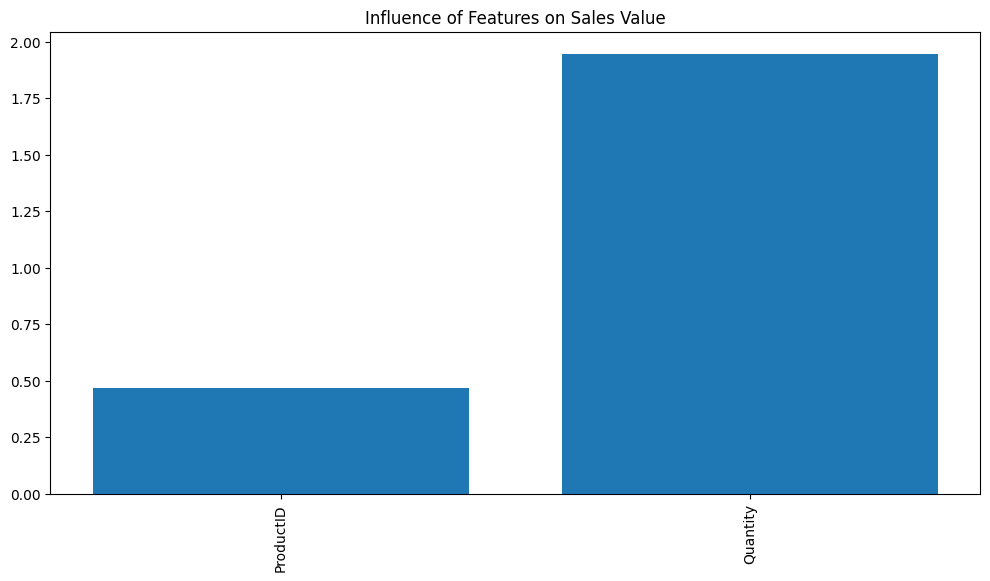

In [17]:
logreg_model = LogisticRegression(random_state=17)

X = retail.drop(columns=['SalesQuartile','Discount','InvoiceID','high_value','CustomerID','Date','TotalSales'], axis=1)
y = retail['high_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)

feature_importances = pd.DataFrame(data={"Feature": X.columns, "Importance": logreg_model.coef_[0]}).sort_values(by='Importance')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xticks(rotation=90)
plt.title("Influence of Features on Sales Value")
plt.show()

Feature Engineering. Creating new features using datetime attributes.

In [18]:
retail['DayOfWeek'] = retail.Date.dt.dayofweek
retail['DayOfYear'] = retail.Date.dt.day_of_year
retail['Quarter'] = retail.Date.dt.quarter
retail['Year'] = retail.Date.dt.year
retail['DayName'] = retail.Date.dt.day_name()
retail.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,SalesQuartile,high_value,DayOfWeek,DayOfYear,Quarter,Year,DayName
0,328,2019-12-27,1684,796.610169,143.389831,185,4,2,False,4,361,4,2019,Friday
1,329,2019-12-27,524,355.932203,64.067797,185,2,1,False,4,361,4,2019,Friday
2,330,2019-12-27,192,901.694915,162.305085,230,4,2,False,4,361,4,2019,Friday
3,330,2019-12-27,218,182.754237,32.895763,230,1,1,False,4,361,4,2019,Friday
4,330,2019-12-27,247,780.101695,140.418305,230,4,2,False,4,361,4,2019,Friday


In [19]:
retail.Date.unique()

array(['2019-12-27T00:00:00.000000000', '2019-12-28T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', ...,
       '2023-03-18T00:00:00.000000000', '2023-03-20T00:00:00.000000000',
       '2023-01-12T00:00:00.000000000'], dtype='datetime64[ns]')

Creating an interative plotly histogram to examine the quarterly sales by year. De-select/Select years in the legend to examine further.

In [20]:
retail_sorted_qtrs = retail.sort_values(by=['Year','Quarter'])
histo = px.histogram(data_frame=retail_sorted_qtrs, x='Quarter', y='TotalSales', color='Year', text_auto=True, title='Quarterly Sales 2019-2023')

histo.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1, 2, 3, 4],
        ticktext = ['Q1','Q2','Q3','Q4'],
        ticks="outside",
        tickson="boundaries",
        ticklen=10,
        showdividers=True,
        linecolor='black'
    ),
    title_x=0.5,
    yaxis = dict (
        linecolor='black',
        spikemode='across+marker',
        spikesnap='hovered data',
        spikethickness=2,
        title='Total Sales',
        gridcolor='black'
    ),
    bargap=0.3,
    paper_bgcolor='whitesmoke',
    plot_bgcolor='whitesmoke'
)

histo.write_html('/kaggle/working/SalesByQuarters.html')
histo.show()

In [21]:
retail_sorted_days = retail.sort_values(by=['Year','DayOfWeek'])
histo = px.histogram(data_frame=retail_sorted_days, x='DayName', y='TotalSales', color='Year', text_auto=True, title='Sales by Day 2019-2023')

histo.update_layout(
    xaxis = dict(
        #tickmode = 'array',
        #tickvals = [1, 2, 3, 4],
        #ticktext = ['Q1','Q2','Q3','Q4'],
        ticks="outside",
        tickson="boundaries",
        ticklen=10,
        showdividers=True,
        linecolor='black'
    ),
    title_x=0.5,
    yaxis = dict (
        linecolor='black',
        spikemode='across+marker',
        spikesnap='hovered data',
        spikethickness=2,
        title='Total Sales',
        gridcolor='black'
    ),
    bargap=0.3,
    paper_bgcolor='whitesmoke',
    plot_bgcolor='whitesmoke'
)

In [22]:
histo = px.histogram(data_frame=retail_sorted_qtrs, x='Quarter', y='Discount', color='Year', text_auto=True, title='Discount $ Issued by Quarter 2019-2023')

histo.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1, 2, 3, 4],
        ticktext = ['Q1','Q2','Q3','Q4'],
        ticks="outside",
        tickson="boundaries",
        ticklen=10,
        showdividers=True,
        linecolor='black'
    ),
    title_x=0.5,
    yaxis = dict (
        linecolor='black',
        spikemode='across+marker',
        spikesnap='hovered data',
        spikethickness=2,
        title='Total Sales',
        gridcolor='black'
    ),
    bargap=0.3,
    paper_bgcolor='whitesmoke',
    plot_bgcolor='whitesmoke'
)

In [23]:
sales_time = px.funnel_area(data_frame=retail, names='Year', values='TotalSales', color='Year', title='Sales 2019-2023')

sales_time.update_layout(
    xaxis = dict(
        tickmode = 'array',
        #tickvals = [1, 2, 3, 4],
        #ticktext = ['Q1','Q2','Q3','Q4'],
        ticks="outside",
        tickson="boundaries",
        ticklen=10,
        showdividers=True,
        linecolor='black'
    ),
    title_x=0.5,
    yaxis = dict (
        linecolor='black',
        spikemode='across+marker',
        spikesnap='hovered data',
        spikethickness=2,
        title='Total Sales',
        gridcolor='black'
    ),
    bargap=0.3,
    paper_bgcolor='whitesmoke',
    plot_bgcolor='whitesmoke'
)

In [24]:
retail.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,SalesQuartile,high_value,DayOfWeek,DayOfYear,Quarter,Year,DayName
0,328,2019-12-27,1684,796.610169,143.389831,185,4,2,False,4,361,4,2019,Friday
1,329,2019-12-27,524,355.932203,64.067797,185,2,1,False,4,361,4,2019,Friday
2,330,2019-12-27,192,901.694915,162.305085,230,4,2,False,4,361,4,2019,Friday
3,330,2019-12-27,218,182.754237,32.895763,230,1,1,False,4,361,4,2019,Friday
4,330,2019-12-27,247,780.101695,140.418305,230,4,2,False,4,361,4,2019,Friday


Including the new datetime features in the logistic regression model to predict for a high_value sale. This shows an improved F1 score of ~0.6 over the ~0.5 in the initial model.

Accuracy: 0.8285419768640476
Precision: 0.6963772282921219
Recall: 0.5555045871559633
F1 Score: 0.6180147996937995


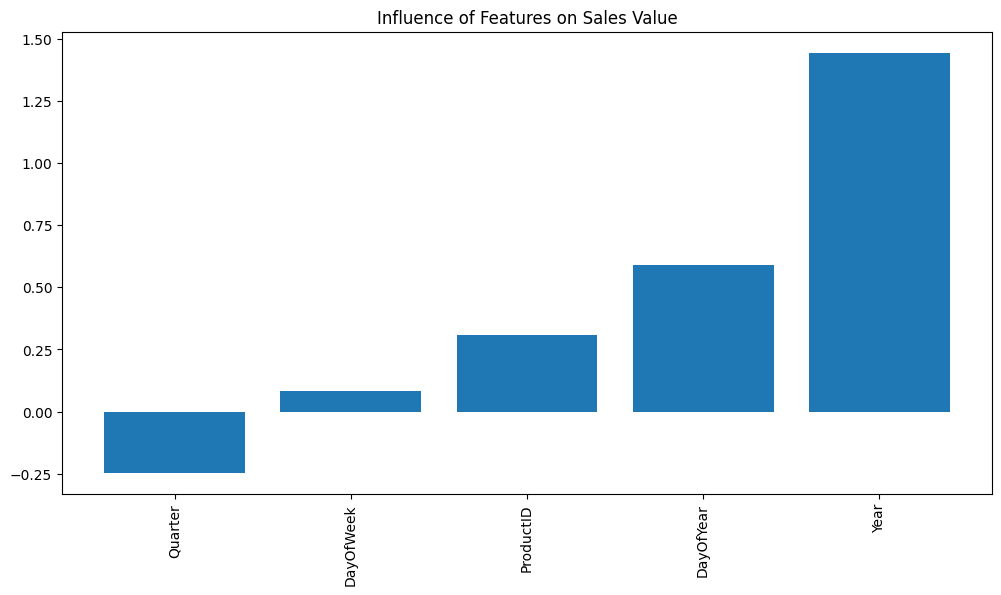

In [25]:
logreg_model2 = LogisticRegression(random_state=17)

X = retail.drop(columns=['SalesQuartile','Discount','InvoiceID','high_value','CustomerID','Date','TotalSales','DayName','Quantity'], axis=1)
y = retail['high_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg_model2.fit(X_train, y_train)

y_pred = logreg_model2.predict(X_test)

feature_importances = pd.DataFrame(data={"Feature": X.columns, "Importance": logreg_model2.coef_[0]}).sort_values(by='Importance')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xticks(rotation=90)
plt.title("Influence of Features on Sales Value")
plt.show()